### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [1]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

== Conda 环境检查报告 (仅针对当前 Bash 子进程) ==
✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。
✅ 正在使用的环境路径: /workspace/envs/flyai_agent_in_action

💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。
   如果需要后续单元格也使用此环境，请执行以下操作:
   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。


In [2]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


Writing to /root/.config/pip/pip.conf
Note: you may need to restart the kernel to use updated packages.
global.index-url='https://pypi.tuna.tsinghua.edu.cn/simple'
:env:.target=''
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

env: HF_ENDPOINT=https://hf-mirror.com
https://hf-mirror.com


In [4]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
### 环境信息
| 项目         | 信息                                                                  |
|:-------------|:----------------------------------------------------------------------|
| 操作系统     | Linux 5.15.0-126-generic                                              |
| CPU 信息     | Intel(R) Xeon(R) Platinum 8468 (48 physical cores, 192 logical cores) |
| 内存信息     | 2015.36 GB (Available: 1867.88 GB)                                    |
| GPU 信息     | No GPU found (checked nvidia-smi, lshw not found)                     |
| CUDA 信息    | 12.6                                                                  |
| Python 版本  | 3.12.11                                                               |
| Conda 版本   | conda 25.7.0                                                          |
| 物理磁盘空间 | Total: 2014.78 GB, Used: 651.70 GB, Free: 1260.66 GB                  |


# 过滤与裁剪对话消息（Filtering and Trimming Messages）

## 回顾

到目前为止，我们已经进一步理解了以下内容：

- 如何自定义图状态（Graph State）的数据模式（Schema）
- 如何定义自定义的状态归约器器（State Reducers）
- 如何在一个项目中使用多种图状态 Schema

## 目标

接下来，我们将在 LangGraph 中把这些概念用于实际模型调用。

在后续章节里，我们会逐步构建一个支持长期记忆的聊天机器人。

**因为机器人依赖消息来对话，我们先介绍在图状态中处理消息的几种高级方式：过滤（Filter）与裁剪（Trim）。**

In [5]:
%%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

In [6]:
import os, getpass

# 小工具：若环境变量未设置，则在运行时提示手动输入并写入到进程环境变量
# 生产环境建议通过更安全的方式（如 .env、密钥管理服务、CI/CD 注入）设置

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# OpenAI API 密钥（用于 ChatOpenAI 调用）
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY:  ········
OPENAI_BASE_URL:  ········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[调用追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)。

本笔记会将追踪数据记录到项目 `langchain-academy` 中。

In [7]:
# LangSmith 用于链路追踪与可视化分析
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
# 指定追踪项目名，便于区分不同实验/环境
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"

LANGSMITH_API_KEY:  ········


## 将消息作为状态（Messages as State）

首先，我们先定义一些对话消息。

In [8]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

# 定义一组对话消息（先是 AI，再是人类），用于后续示例
messages = [AIMessage(f"你之前说你在研究海洋哺乳动物，对吗？", name="Bot")]
messages.append(HumanMessage(f"是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance"))
# 以更易读的格式打印消息，便于调试与理解
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？


回顾一下：我们可以直接把这组消息传给聊天模型。

In [9]:
from langchain_openai import ChatOpenAI

# 初始化聊天模型；gpt-4o 仅为示例，可根据账号权限与成本选择其他模型
llm = ChatOpenAI(model="gpt-4o")

# 直接将完整消息历史传入模型（注意：长对话会推高 token 与延迟）
llm.invoke(messages)

AIMessage(content='除了鲸鱼之外，海洋哺乳动物还有海豚、海豹、海狮、海象、儒艮和江猪。\n\n1. **海豚**：它们是高度智能的生物，属于齿鲸亚目，许多种类有着复杂的社会结构。\n\n2. **海豹**：属于鳍足类，常见于海岸和帆船上。它们通过水中的鳍进行游泳。\n\n3. **海狮**：也属于鳍足类，区别在于它们具有外耳壳，并能利用鳍在陆地上行走。\n\n4. **海象**：以巨大的獠牙和健壮的体型闻名，它们主要依靠饮食中的软体动物。\n\n5. **儒艮**：一种草食性海洋哺乳动物，以海草为食，有时易被误认为是“美人鱼”。\n\n6. **江猪**：即淡水豚类，它们生活在淡水区域，并以其独特的生态角色闻名。\n\n每种海洋哺乳动物都有独特的行为、生态角色和进化特征。了解这些生物不仅能够对它们的保护提供帮助，亦能丰富对海洋生态系统的整体认识。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 290, 'prompt_tokens': 45, 'total_tokens': 335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_8458c98457', 'id': 'chatcmpl-CLKxqFJmzs6p4f3rmg3wNrFUYDMzR', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--415fc185-35d1-4672-915f-f57c28fd387a-0', usage_metadata={'input_tok

我们可以在一个使用 `MessagesState` 的简单图（Graph）里运行聊天模型。

In [11]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# 定义一个图节点：接收状态中的所有消息，直接调用聊天模型
# 注意：此处未做任何过滤/裁剪，长对话会不断增长

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# 构建最简图：START -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 展示图结构
# 图可视化
print("图可视化：")

# 方案1：尝试使用 Pyppeteer 本地渲染（推荐）
try:
    # 可视化：通过 Mermaid 渲染图结构
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("✅ 图渲染成功！")
except Exception as e:
    print(f"❌ Pyppeteer 渲染失败: {e}")
    
    # 方案2：显示 Mermaid 文本格式
    print("\n📝 图结构（Mermaid 文本格式）：")
    print("=" * 50)
    mermaid_text = graph.get_graph().draw_mermaid()
    print(mermaid_text)
    print("=" * 50)
    
    # 方案3：显示图的节点和边信息
    print("\n🔗 图结构信息：")
    print("节点:", list(graph.get_graph().nodes.keys()))
    print("边:", list(graph.get_graph().edges))
    
    # 方案4：提供手动渲染说明
    print("\n💡 手动渲染说明：")
    print("1. 复制上面的 Mermaid 文本")
    print("2. 访问 https://mermaid.live/")
    print("3. 粘贴文本到编辑器中查看图形")
    print("4. 或者使用支持 Mermaid 的 Markdown 编辑器")

图可视化：
❌ Pyppeteer 渲染失败: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

📝 图结构（Mermaid 文本格式）：
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chat_model(chat_model)
	__end__([<p>__end__</p>]):::last
	__start__ --> chat_model;
	chat_model --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


🔗 图结构信息：
节点: ['__start__', 'chat_model', '__end__']
边: [Edge(source='__start__', target='chat_model', data=None, conditional=False), Edge(source='chat_model', target='__end__', data=None, conditional=False)]

💡 手动渲染说明：
1. 复制上面的 M

In [12]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼之外，还有几个主要的海洋哺乳动物类别值得关注：

1. **海豚**：海豚是鲸目中的一部分，与鲸鱼关系密切。它们以智慧和社会行为而闻名。

2. **海狮**：海狮属于鳍足动物，通常较为活跃，并且喜欢在海岸线附近活动。

3. **海豹**：与海狮类似，海豹也是鳍足动物。它们通常在更冷的水域中被发现，并以其流线型的身体著称。

4. **海象**：海象以其巨大的体型和显著的长牙而闻名，主要栖息在北极和亚北极地区。

5. **儒艮和海牛**：也被称为美人鱼或海牛，儒艮和海牛是食草动物，常在热带和亚热带水域被发现。

这些动物都有独特的适应性和行为模式，使它们在海洋环境中成功生存。如果你对海洋哺乳动物的生态、保护和行为感兴趣，这些都是很好的研究对象。


## 归约器（Reducer）

在处理消息时，一个实际挑战是管理“长对话”。

如果不加控制，随着对话历史不断增长，模型每次都会接收越来越长的消息列表，导致令牌（token）消耗增大、延迟升高。

为了解决这个问题，我们有几种常用方法。

首先，回顾之前的技巧：使用 `RemoveMessage` 配合 `add_messages` 归约器来删除不需要的历史消息。

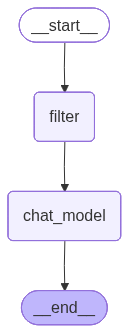

In [13]:
from langchain_core.messages import RemoveMessage

# 过滤节点：仅保留最近 2 条消息，删除更早的历史
# 使用 RemoveMessage + add_messages 归约器的组合语义

def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

# 调用节点：将过滤后的消息传给模型

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# 构建图：START -> filter -> chat_model -> END
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 可视化
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Message list with a preamble
messages = [AIMessage("你好。", name="Bot", id="1")]
messages.append(HumanMessage("你好。", name="Lance", id="2"))
messages.append(AIMessage("你之前说你在研究海洋哺乳动物，对吗？", name="Bot", id="3"))
messages.append(HumanMessage("是的，我知道鲸鱼。但我还应该了解哪些其他的？", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼之外，海洋哺乳动物还有很多种类。以下是一些主要的类别和例子：

1. **海豚**：海豚是非常聪明的海洋哺乳动物，属于齿鲸类。常见的有瓶鼻海豚和普通海豚。

2. **鼠海豚**：鼠海豚类似于海豚，但通常体型较小，且身体更为圆润。常见的种类包括港湾鼠海豚。

3. **海豹**：海豹是鳍脚类动物之一，适应水陆两栖生活。常见的有斑海豹、灰海豹和象海豹。

4. **海狮和海狗**：虽然名字中有“狮”和“狗”，但它们都是鳍脚类动物。海狮的特点是有外耳廓而海豹没有，常见的有加州海狮和南美海狮。

5. **海象**：海象是大型鳍脚类动物，拥有长长的獠牙和叫作胡须的触须，是北极地区的代表性物种。

6. **儒艮和美人鱼（海牛）**：这些是温暖水域的食草动物。儒艮和美人鱼在生态上非常重要，帮助保持海草床的健康。

7. **极地熊（北极熊）**：虽然北极熊主要在陆地或冰面上活动，它们被认为是海洋哺乳动物，因为大部分生活依赖于海洋环境。

这些动物各有独特的适应性和生态角色，是海洋生态系统的重要组成部分。了解每一种类的生活习性和保护措施会对研究海洋哺乳动物非常有帮助。


## 过滤消息（Filtering Messages）

如果你不需要或不想修改图状态本身，可以只对“传入聊天模型的消息列表”进行过滤。

例如，仅把最后一条消息传给模型：`llm.invoke(messages[-1:])`。

In [16]:
# 仅传入“最后一条消息”给模型，避免把整段历史都送入模型
# 注意：这种方式适用于上下文依赖较弱的问答；若强依赖上下文，请考虑裁剪（trim）而非简单过滤

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# 展示图结构
# 图可视化
print("图可视化：")

# 方案1：尝试使用 Pyppeteer 本地渲染（推荐）
try:
    # 可视化：通过 Mermaid 渲染图结构
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("✅ 图渲染成功！")
except Exception as e:
    print(f"❌ Pyppeteer 渲染失败: {e}")
    
    # 方案2：显示 Mermaid 文本格式
    print("\n📝 图结构（Mermaid 文本格式）：")
    print("=" * 50)
    mermaid_text = graph.get_graph().draw_mermaid()
    print(mermaid_text)
    print("=" * 50)
    
    # 方案3：显示图的节点和边信息
    print("\n🔗 图结构信息：")
    print("节点:", list(graph.get_graph().nodes.keys()))
    print("边:", list(graph.get_graph().edges))
    
    # 方案4：提供手动渲染说明
    print("\n💡 手动渲染说明：")
    print("1. 复制上面的 Mermaid 文本")
    print("2. 访问 https://mermaid.live/")
    print("3. 粘贴文本到编辑器中查看图形")
    print("4. 或者使用支持 Mermaid 的 Markdown 编辑器")

图可视化：
❌ Pyppeteer 渲染失败: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

📝 图结构（Mermaid 文本格式）：
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chat_model(chat_model)
	__end__([<p>__end__</p>]):::last
	__start__ --> chat_model;
	chat_model --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


🔗 图结构信息：
节点: ['__start__', 'chat_model', '__end__']
边: [Edge(source='__start__', target='chat_model', data=None, conditional=False), Edge(source='chat_model', target='__end__', data=None, conditional=False)]

💡 手动渲染说明：
1. 复制上面的 M

接下来，我们把现有消息列表继续扩展：先加入上面的 LLM 回复，再追加一个追问。

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"再告诉我一些关于独角鲸的事吧！", name="Lance"))

In [18]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼之外，海洋哺乳动物还有很多种类。以下是一些主要的类别和例子：

1. **海豚**：海豚是非常聪明的海洋哺乳动物，属于齿鲸类。常见的有瓶鼻海豚和普通海豚。

2. **鼠海豚**：鼠海豚类似于海豚，但通常体型较小，且身体更为圆润。常见的种类包括港湾鼠海豚。

3. **海豹**：海豹是鳍脚类动物之一，适应水陆两栖生活。常见的有斑海豹、灰海豹和象海豹。

4. **海狮和海狗**：虽然名字中有“狮”和“狗”，但它们都是鳍脚类动物。海狮的特点是有外耳廓而海豹没有，常见的有加州海狮和南美海狮。

5. **海象**：海象是大型鳍脚类动物，拥有长长的獠牙和叫作胡须的触须，是北极地区的代表性物种。

6. **儒艮和美人鱼（海牛）**：这些是温暖水域的食草动物。儒艮和美人鱼在生态上非常重要，帮助保持海草床的健康。

7. **极地熊（北极熊）**：虽然北极熊主要在陆地或冰面上活动，它们被认为是海洋哺乳动物，因为大部分生活依赖于海洋环境。

这些动物各有独特的适应性和生态角色，是海洋生态系统的重要组成部分。了解每一种类的生活习性和保护措施会对研究海洋哺乳动物非常有帮助。
=====

In [19]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

你好。
================================ Human Message =================================
Name: Lance

你好。
================================== Ai Message ==================================
Name: Bot

你之前说你在研究海洋哺乳动物，对吗？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的？
================================== Ai Message ==================================

除了鲸鱼之外，海洋哺乳动物还有很多种类。以下是一些主要的类别和例子：

1. **海豚**：海豚是非常聪明的海洋哺乳动物，属于齿鲸类。常见的有瓶鼻海豚和普通海豚。

2. **鼠海豚**：鼠海豚类似于海豚，但通常体型较小，且身体更为圆润。常见的种类包括港湾鼠海豚。

3. **海豹**：海豹是鳍脚类动物之一，适应水陆两栖生活。常见的有斑海豹、灰海豹和象海豹。

4. **海狮和海狗**：虽然名字中有“狮”和“狗”，但它们都是鳍脚类动物。海狮的特点是有外耳廓而海豹没有，常见的有加州海狮和南美海狮。

5. **海象**：海象是大型鳍脚类动物，拥有长长的獠牙和叫作胡须的触须，是北极地区的代表性物种。

6. **儒艮和美人鱼（海牛）**：这些是温暖水域的食草动物。儒艮和美人鱼在生态上非常重要，帮助保持海草床的健康。

7. **极地熊（北极熊）**：虽然北极熊主要在陆地或冰面上活动，它们被认为是海洋哺乳动物，因为大部分生活依赖于海洋环境。

这些动物各有独特的适应性和生态角色，是海洋生态系统的重要组成部分。了解每一种类的生活习性和保护措施会对研究海洋哺乳动物非常有帮助。
=====

图状态中仍然保存着全部消息。

不过，从 LangSmith 的追踪可以看到：模型实际调用时只使用了最后一条消息。

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## 裁剪消息（Trim Messages）

另一种方式是按令牌数对历史进行“裁剪”（trim）：即通过 [`trim_messages`](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens) 限制用于本次回复的历史消息总令牌数。

- 过滤（filter）：只是事后挑选一部分消息传给模型；
- 裁剪（trim）：从头/尾等策略出发，严格限制可用的历史上下文所占令牌数。

下面演示如何使用 `trim_messages`。

In [21]:
from langchain_core.messages import trim_messages

# 节点：对“历史消息”按令牌数进行裁剪，再调用模型
# - max_tokens：历史消息允许占用的最大 token 数
# - strategy：裁剪策略（"last" 表示优先保留靠后的消息）
# - token_counter：用于估算 token 数的模型或计数器
# - allow_partial：为 False 时，不会截断单条消息的一部分（保证每条消息的完整性）

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# 构建图
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()


# 展示图结构
# 图可视化
print("图可视化：")

# 方案1：尝试使用 Pyppeteer 本地渲染（推荐）
try:
    # 可视化：通过 Mermaid 渲染图结构
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("✅ 图渲染成功！")
except Exception as e:
    print(f"❌ Pyppeteer 渲染失败: {e}")
    
    # 方案2：显示 Mermaid 文本格式
    print("\n📝 图结构（Mermaid 文本格式）：")
    print("=" * 50)
    mermaid_text = graph.get_graph().draw_mermaid()
    print(mermaid_text)
    print("=" * 50)
    
    # 方案3：显示图的节点和边信息
    print("\n🔗 图结构信息：")
    print("节点:", list(graph.get_graph().nodes.keys()))
    print("边:", list(graph.get_graph().edges))
    
    # 方案4：提供手动渲染说明
    print("\n💡 手动渲染说明：")
    print("1. 复制上面的 Mermaid 文本")
    print("2. 访问 https://mermaid.live/")
    print("3. 粘贴文本到编辑器中查看图形")
    print("4. 或者使用支持 Mermaid 的 Markdown 编辑器")

图可视化：
❌ Pyppeteer 渲染失败: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

📝 图结构（Mermaid 文本格式）：
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chat_model(chat_model)
	__end__([<p>__end__</p>]):::last
	__start__ --> chat_model;
	chat_model --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


🔗 图结构信息：
节点: ['__start__', 'chat_model', '__end__']
边: [Edge(source='__start__', target='chat_model', data=None, conditional=False), Edge(source='chat_model', target='__end__', data=None, conditional=False)]

💡 手动渲染说明：
1. 复制上面的 M

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [23]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [24]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})

最后，我们再通过 LangSmith 追踪看看本次模型调用的实际入参情况：

![image-20250930110917504](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509301109900.png)